# Part 2 - Recontruction on calibration run

Having proceded to rearrenge the data, we now start with the analysis.

### Fit Functions

In [ ]:
import itertools
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from multiprocessing import Process, Manager, Pool
import multiprocessing as mp
from tqdm import tqdm
from scipy.stats.kde import gaussian_kde
from matplotlib.patches import Rectangle

%matplotlib inline 

XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

<ipython-input-1-0b63349576f1>:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde



In this section, we performed a linear fit of the event to determine the hit that has the best alignment, i.e the events that hit at least three layers. We chose our good event based on the chi-square and the R square values. 
We defined the three functions to carry out these operations:

1.`get_binary_permutations`: This function is used to iterate through the rows to get the possible permutations of hits in at least three layers of a chamber.

2.`fit_event`: This function is used to find the right-left combination that best fits. First, we perform a linear fit on all the possible combinations of the first n_hits in the dataset, then for the remaining hits we choose the x coordinate that is more linearly correlated with the other dataset

3.`global_fit_event`: Use the local fits to find the best fit that interpolates with all the hits in the different chambers



In [ ]:
def get_binary_permutations(n):
    r"""
    Returns all possible combinations of 0.1 of size n.
    Ex: n = 3 -> (0,0,0), (0,1,0), (1,0,0), (0,0,1), (1,1,0), ...., (1,1,1)
    
    :param n: number of element in each permutation
    
    :return: permutation
    """
    comb = list(itertools.combinations_with_replacement(range(2), n))
    bp = [comb[0]]
    for c in comb[1:-1]:
        bp += list(itertools.permutations(c, len(c)))
    bp += [comb[-1]]
    return np.array(bp)

def fit_event(event, chambers=None, n=3):
    r"""

    :param event:     pandas Series representing the event;
    :param chambers:  chambers to analyze, if None chambers will be found automatically;
    :param n:         numbers of hits to permute, default 3;
    
    :return: 
        res,          results for each hit: x, z, best_perm, best_chi2, best_fit;
        hits_left,    all the left coords for each hit;
        hits_right    all the right coords for each hit;
    """
    hits = event[event.notna()]
    max_hits = int(event.number_hits)
    
    # Identify the chambers where there are hits
    if chambers is None:
        chambers = np.unique([hits[f'hit_{i}_chamber'] for i in range(max_hits) 
                              if f'hit_{i}_chamber' in hits.keys()])
    
    res = {}
    hits_left, hits_right = {}, {}
    for chamber in chambers:
        # Idx of the hits in the chamber
        hits_in_chamber = np.unique([i for i in range(max_hits + 1) if f'hit_{i}_chamber' in hits.keys() 
                                     and (int(hits[f'hit_{i}_chamber']) == int(chamber))])
        
        hits_ch = pd.DataFrame({'xleft': [hits[f'hit_{i}_xleft'] for i in hits_in_chamber], 
                                'xright': [hits[f'hit_{i}_xright'] for i in hits_in_chamber], 
                                'layer': [hits[f'hit_{i}_layer'] for i in hits_in_chamber] })
        
        # If there are less hits than n use the number of hits in the chamber  
        n_perm_elements = min(n, len(hits_ch))

        if len(hits_in_chamber) < 3:
            continue

        # hits_ch = hits_ch.sort_values('layer')
        hits_ch.set_axis(list(range(len(hits_ch))), inplace=True)
        z = hits_ch[:n_perm_elements].layer
        
        perm = get_binary_permutations(n_perm_elements)
        # 0 <=> xleft, 1 <=> xright
        keys = np.array(['xleft', 'xright'])
        
        fit_params = None
        best_chi2 = None
        best_perm = None
        for p in perm:
            # Test all the possible left-right permutations of n hits (perm)
            x = np.array([hits_ch[:n_perm_elements].loc[i, k] for i, k in enumerate(keys[p])])
            res_fit = stats.linregress(x, z) # Fit the data
            z_hat = x * res_fit.slope + res_fit.intercept # Compute expected values
            
            #r2= res_fit.rvalue**2

            # Compute the Chi2
            e = res_fit.stderr ** 2 * x ** 2 + res_fit.intercept_stderr**2
            chi2 = np.sum(((z - z_hat)**2) / e)

            #chi2
            
            if best_chi2 is None or best_chi2 > chi2:
                best_chi2 = chi2
                fit_params = res_fit
                best_perm = list(p)
                
        x = np.array([hits_ch[:n_perm_elements].loc[i, k] for i, k in enumerate(keys[best_perm])])
        best_fit = fit_params
        for i in range(n_perm_elements, len(hits_ch)):
            # For the remaining hits, we test each time if the left or right coordinate better fit with
            # the other data
            
            xleft = np.append(x, hits_ch.loc[i].xleft)
            xright = np.append(x, hits_ch.loc[i].xright)
            z = hits_ch[:len(xleft)].layer
            
            res_xleft = stats.linregress(xleft, z)
            z_hat_left = xleft * res_xleft.slope + res_xleft.intercept
            e = res_xleft.stderr ** 2 * xleft ** 2 + res_xleft.intercept_stderr**2
            chi2_left = np.sum(((z - z_hat_left)**2) / e)
            
            res_xright = stats.linregress(xright, z)
            z_hat_right = xright * res_xright.slope + res_xright.intercept
            e = res_xright.stderr ** 2 * xright ** 2 + res_xright.intercept_stderr**2
            chi2_right = np.sum(((z - z_hat_right)**2) / e)

            #Condition for selection of "goodness of event"

            if chi2_left < chi2_right:
                x = xleft
                best_perm.append(0)
                best_chi2 = chi2_left
                best_fit = res_xleft
            else:
                x = xright
                best_perm.append(1)
                best_chi2 = chi2_right
                best_fit = res_xright
                
        # Fill the dictionary with the results
        hits_right[chamber] = hits_ch.xright
        hits_left[chamber] = hits_ch.xleft
        res[chamber] = [x, z, best_perm, best_chi2, best_fit]
    return res, hits_left, hits_right

def global_fit_event(event, chambers=None, n=3, return_chambers_fit=False):
    r"""
   
    param event:     pandas Series representing the event;
    param chambers:  chambers to analyze, if None chambers will be found automatically;
    param n:         numbers of hits to permute, default 3;
    
    return: 
        res,          results
    """
    res, hits_left, hits_right = fit_event(event, chambers=chambers, n=n)

    ret_res = {0: [[], [], [], 0., None]}
    ret_hits_left = {0 : []}
    ret_hits_right = {0 : []}
    
    if len(res.keys()) == 0:
        return {}, {}, {}

    chambers = tuple(res.keys())
    if chambers not in [(0, 1), (1, 0), (2, 3), (3, 2)]:
        return {}, {}, {}
    
    for chamber in res.keys():
        x, z, best_perm, best_chi2, best_fit = res[chamber]

        ret_hits_left[0] = np.append(ret_hits_left[0], hits_left[chamber])
        ret_hits_right[0] = np.append(ret_hits_right[0], hits_right[chamber])

        ret_res[0][0] = np.append(ret_res[0][0], x)
        ret_res[0][1] = np.append(ret_res[0][1], z)
        ret_res[0][2] = np.append(ret_res[0][2], best_perm)
    
    best_fit = stats.linregress(ret_res[0][0], ret_res[0][1])
    z_hat = ret_res[0][0] * best_fit.slope + best_fit.intercept
    e = best_fit.stderr ** 2 * ret_res[0][0] ** 2 + best_fit.intercept_stderr**2

    best_chi2 = np.sum(((ret_res[0][1] - z_hat)**2) / e)
    ret_res[0][3] = best_chi2
    ret_res[0][4] = best_fit
    
    if return_chambers_fit:
        return {'global': [ret_res, ret_hits_left, ret_hits_right], 'local': [res, hits_left, hits_right]}
    else:
        return ret_res, ret_hits_left, ret_hits_right

## Point d - Events display with their fit

### Plot Functions

The function `plot_event` call the function `global_fit_event` to perform the linear fit, and then plot into a graph the hits (left and right on each layer) and the corresponing fit.

The function `good_event` is a function for the selection of good events. In particular, we are requiring that the events need to have a `r**2 = 1` from the results of the linear regression.

The function `_worker` apply the function above to the workers, since the code is written to take advantage of a multicore cpu.

The function `plot_data` is used to visualize all the events in the data. If `plot_as_heatmap = True`, an heatmap is created in order to represent the path of the muons. If `use_global_fit = True` we are plotting the global fit, if `False` we are plotting the local one.
If num_workers > num_cpu the performances will not improve


In [ ]:
# The plot functions to diplay the events on the plot including the selection of good events to fit.
def plot_event(event, chambers=None, plot_only_fit=True):
    r"""
    Visualize an event.
    
    :param event:         pandas Series representing the event;
    :param chambers:      chambers to analyze, if None chambers will be found automatically;
    :param plot_only_fit: plot only the data in the fit or plot even the left-right data;
    
    :return: 
    """
    if int(event.number_hits) == 0:
        print (f'No hits detected for event {int(event.event_number)}')
        return
    dic = global_fit_event(event, chambers=chambers, n=3, return_chambers_fit=True)
    res, hits_left, hits_right = dic['local']
    print(f'Hits in chambers: {res.keys()}')
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.xlim([-1000, 1000])
    plt.ylim([-100, 1000])
    for chamber in res.keys():
        x, z, best_perm, best_chi2, best_fit = res[chamber]
        if best_fit is not None:
            x_hat = np.linspace(-950, 950, 1000)
            z_hat =  x_hat * best_fit.slope + best_fit.intercept
            m = np.logical_and(z_hat < 950, z_hat > -50)
            ax.plot(x_hat[m], z_hat[m], 'g--', label = 'Local fit')
            ax.plot(x, z, 'gx', markersize=6)

            if not plot_only_fit:
                ax.plot(hits_left[chamber], z, 'ro', markersize=3)
                ax.plot(hits_right[chamber], z, 'bo', markersize=3)
    global_fit = dic['global'][0][0][4]
    x_hat = np.linspace(-950, 950, 1000)
    z_hat =  x_hat * global_fit.slope + global_fit.intercept
    m = np.logical_and(z_hat < 950, z_hat > -50)
    ax.plot(x_hat[m], z_hat[m], 'g', label='Global fit')
    ax.legend()

    #creates rectangle to rappresent each detector
    ax.add_patch(Rectangle((global_x_shifts[3] - 700, global_z_shifts[0]-ZCELL/2), 700, 4*ZCELL, fill=None,color='gray')) #0
    ax.add_patch(Rectangle((global_x_shifts[2] - 700, -ZCELL/2), 700, 4*ZCELL, fill=None,color='gray')) #1
    ax.add_patch(Rectangle((global_x_shifts[1]- 700, global_z_shifts[0]-ZCELL/2), 700, 4*ZCELL, fill=None,color='gray')) #2
    ax.add_patch(Rectangle((global_x_shifts[0]- 700, -ZCELL/2), 700, 4*ZCELL, fill=None,color='gray')) #3

    plt.xlabel('x [mm]')
    plt.ylabel('z [mm]')
    plt.title(f'Event {int(event.event_number)} - Local and Global fit')
    plt.show()
    
def good_event(fit_res, chi2, r2):
    is_this_a_good_event: bool = True # / False 
    if r2 == 1:
        return is_this_a_good_event

def _worker(f, return_list, i, events, filter_events, *args):
    for index, event in (events.iterrows()):
        ret = f(event, *args) 
        if filter_events:
            if 0 in ret[0].keys():
                r = ret[0]

                fit_res = r[0][4]
                r2 = fit_res.rvalue ** 2
                chi2 = r[0][3]
                accept_reject = good_event(fit_res, chi2, r2)
                if r2 > 0.5: 
                    return_list.append(ret)
        else:
            return_list.append(ret)     
    
def plot_data(data, n=-1, plot_only_fit=True, plot_as_heatmap=False, num_workers=0, use_global_fit=True):
    r"""
    Visualize all the events in data. If plot_as_heatmap an heatmap is created in order to represent the 
    path of the muons. If num_workers > num_cpu the performances will not improve.
    
    :param data:            pandas DataFrame;
    :param n:               use only the first n events;
    :param plot_only_fit:   plot only the data in the fit or plot even the left-right data;
    :param plot_as_heatmap: plot an heatmap to represent the beam;
    :param num_workers:     set to 0 to use a single processor, otherwise num_workers > 0 enable data parallelism;
    :param use_global_fit:  perform local or global fit
  
    :return: 
    """

    fig, ax = plt.subplots(figsize=(11, 8))
    x_min = -1000
    x_max = -x_min
    y_min = -100
    y_max = 1000
    offset = 50
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)        
    results = []
    n_permutation = 3
    chi2 = []
    
    if num_workers==0:
        _worker(fit_event if not use_global_fit else global_fit_event,
                results, 0, data[:n], use_global_fit, None, n_permutation) 

    else:
        splitted = np.array_split(data[:n], num_workers)
        with mp.Manager() as manager:
            return_list = manager.list()
            processes = [mp.Process(target= _worker,
                                    args=(fit_event if not use_global_fit else global_fit_event,
                                          return_list, x, splitted[x], use_global_fit, None, n_permutation))
                         for x in range(num_workers)]
            for p in processes:
                p.start()

            # Exit the completed processes
            for p in processes:
                p.join()

            results = list(return_list)
            
    if plot_as_heatmap:
        all_x = []
        all_z = []
        for k, r in enumerate(results):
            res, hits_left, hits_right = r
            for chamber in res.keys():
                x, z, best_perm, best_chi2, best_fit = res[chamber]
                chi2.append(best_chi2)
                
                if best_fit is not None:
                    x_max_r = (y_max - offset - best_fit.intercept) / (best_fit.slope + 1e-7)
                    x_min_r = (y_min + offset - best_fit.intercept) / (best_fit.slope + 1e-7)
                    n_points = int(np.sqrt((x_max_r - x_min_r) ** 2 + (y_max - y_min - 2 * offset) ** 2) / 5)

                    x_hat = np.linspace(max(x_min + offset, min(x_max_r, x_min_r)),
                                        min(x_max - offset, max(x_max_r, x_min_r)), 10)
                    z_hat =  x_hat * best_fit.slope + best_fit.intercept
                    m = np.logical_and(z_hat < y_max - offset, z_hat > y_min + offset)
                    z_hat = z_hat[m]
                    x_hat = x_hat[m]
                    all_x = np.append(all_x, x_hat)
                    all_z = np.append(all_z, z_hat)
                    
                    if k % 5 == 0: 
                        ax.plot(x_hat, z_hat, 'w--', linewidth=0.5, alpha=0.2)
                        if not plot_only_fit:
                            ax.plot(x, z, 'wx', markersize=6)
                            ax.plot(hits_left[chamber], z, 'ro', markersize=3)
                            ax.plot(hits_right[chamber], z, 'bo', markersize=3)

        #z, xedges, yedges = np.histogram2d(all_x, all_z, 200)
        #ax.pcolormesh(xedges, yedges, z, alpha=0.4, cmap='hot')
        
        k = gaussian_kde(np.vstack([all_x, all_z]), bw_method='silverman')
        xi, yi = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        #ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.8, cmap='hot', shading='auto')
        im = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.8, cmap='hot', shading='auto')
        fig.colorbar(im, ax=ax)

    else:
        for r in results:
            res, hits_left, hits_right = r
            for chamber in res.keys():
                x, z, best_perm, best_chi2, best_fit = res[chamber]
                chi2.append(best_chi2)
                if best_fit is not None:
                    x_hat = np.linspace(x_min + offset, x_max - offset, 1000)
                    z_hat =  x_hat * best_fit.slope + best_fit.intercept
                    m = np.logical_and(z_hat < y_max - offset, z_hat > y_min + offset)
                    ax.plot(x_hat[m], z_hat[m], 'c--', linewidth=0.5)
                    ax.plot(x, z, 'cx', markersize=6)

                    if not plot_only_fit:
                        ax.plot(hits_left[chamber], z, 'ro', markersize=3)
                        ax.plot(hits_right[chamber], z, 'bo', markersize=3)

    plt.xlabel('x [mm]')
    plt.ylabel('z [mm]')
    if use_global_fit:
        plt.title('Traces - Global Fit')
    else:
        plt.title('Traces - Local Fit')
    
    plt.show()
    print(f'Mean Chi2 {np.mean(chi2)}')

The function `plot_select` is basically a call to `plot_event` with some debug checks and the correct event selection.

In [ ]:
def plot_selection (event_number, run_data, plot_only_fits):
    data = pd.read_csv(run_data+'.csv')

    event_list = data.event_number.to_list()
    check_list = event_number not in event_list #the event number inserted exist in the dataframe?

    if check_list == True or event_number < 0: #if not, print error
        print ('Event number not present, try another one...')
    else:
        event = data.loc[data['event_number'] == event_number].iloc[0].dropna()
        plot_event(event, chambers=None, plot_only_fit=plot_only_fits)

Now we apply the funcions to show the traces of the fits, to the calibration runs. Note that, only the first `n=100` element are displayed.

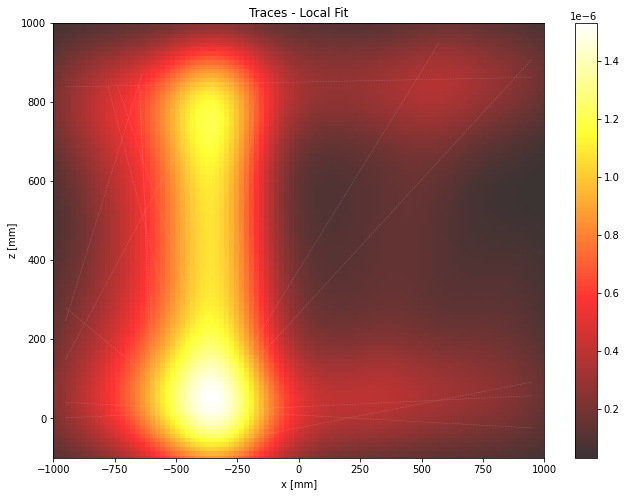

Mean Chi2 1.2042324792303782


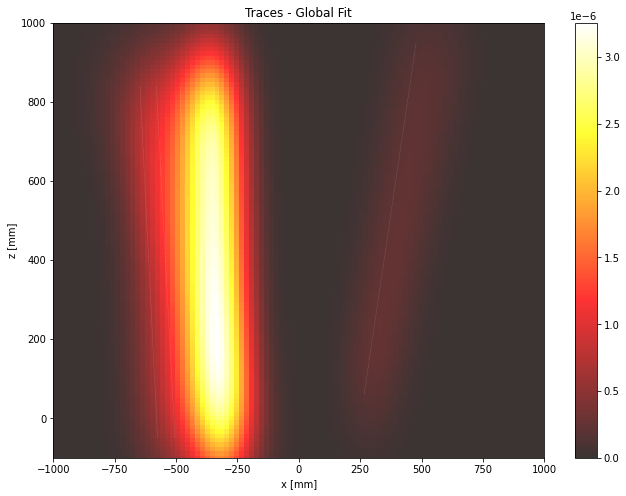

Mean Chi2 0.8798034600293202


In [ ]:
data = pd.read_csv('run_000260_global.csv')

#LOCAL fit
plot_data(data, n=100, plot_only_fit=True, num_workers=0, plot_as_heatmap=True, use_global_fit=False)
#GLOBAL fit
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=True)

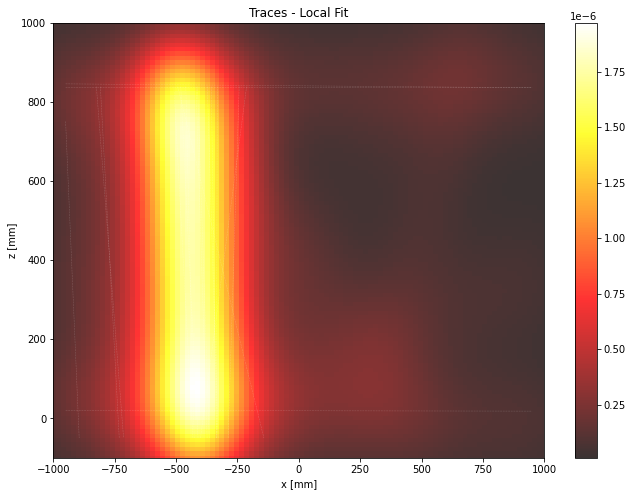

Mean Chi2 0.39560433126337735


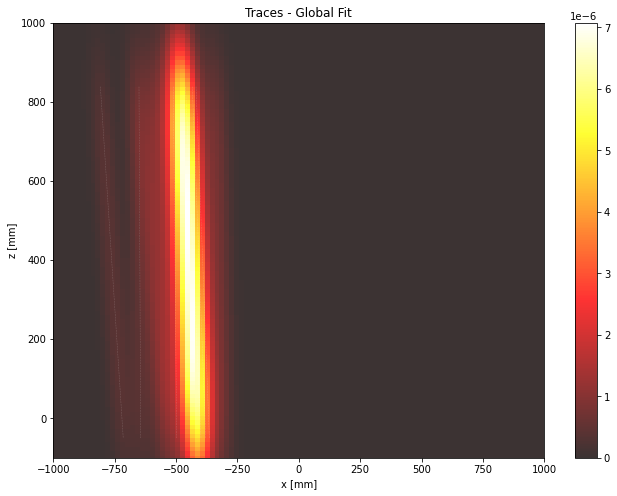

Mean Chi2 0.09801968959620144


In [ ]:
data = pd.read_csv('run_000261_global.csv')
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=False)
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=True)

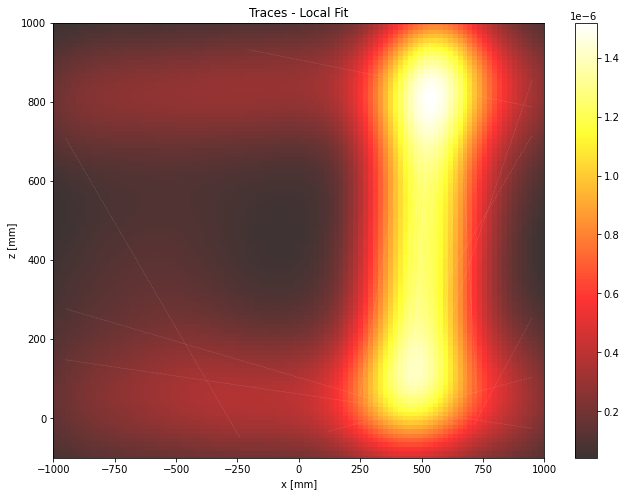

Mean Chi2 1.4205255306044855


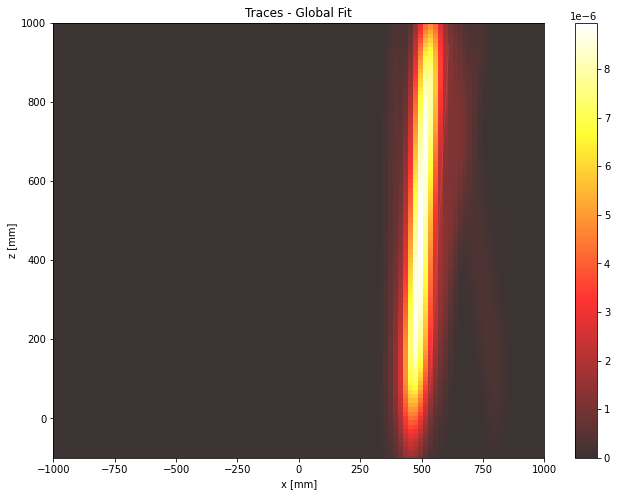

Mean Chi2 0.2976614778466446


In [ ]:
data = pd.read_csv('run_000262_global.csv')
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=False)
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=True)

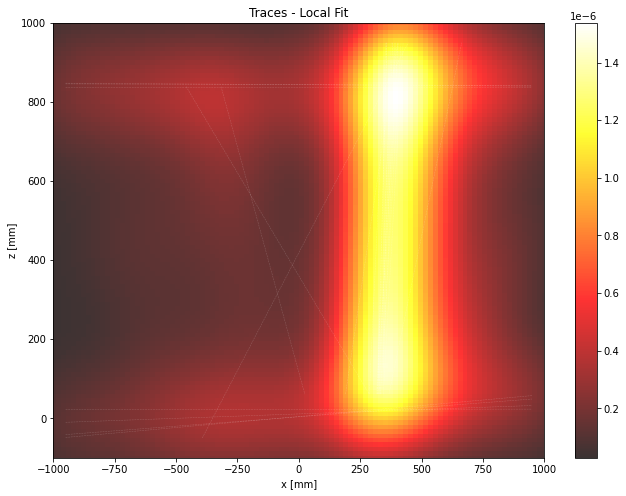

Mean Chi2 0.8914499475313699


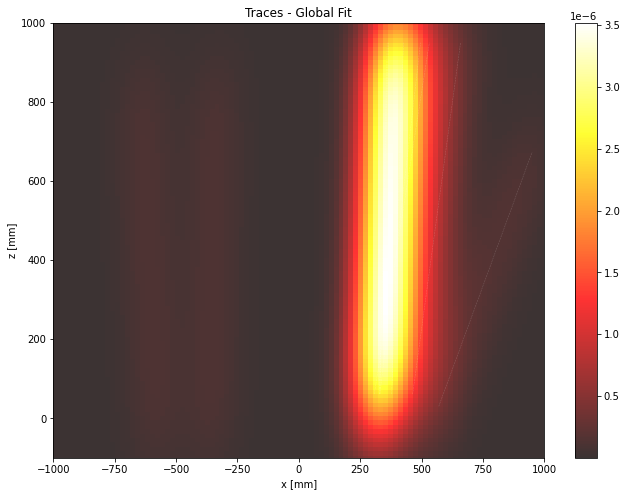

Mean Chi2 0.7078758197709087


In [ ]:
data = pd.read_csv('run_000263_global.csv')
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=False)
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=True)

We can clearly see the effect on the selection of good event: going from the local fit to the global one, we can see a consolidation of the zone where we detect events.
Moreover, like we expected, the first 2 runs shows hits on the left side, while the bottom 2, since the current have the inverse sign (Magnet current below 0 for the first 2 runs, above zero for the last 2 runs), are on the right side.  

#### Local - Global Fit

We perform the local and global fit. The following function take as argument the event we want to analyze and the run where we took it. 
For our purpose, to recreate the image of the project description, we take `Event 19` of the `run_000261_global`.

The local fit is showed as a dashed green line, while the global fit is showed as a solid green line.

Hits in chambers: dict_keys([2.0, 3.0])


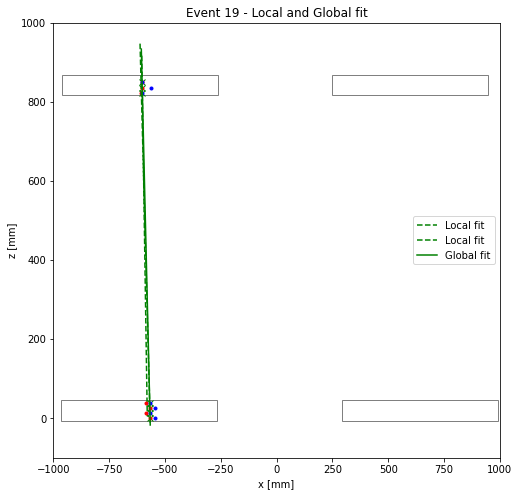

In [ ]:
plot_selection (19, 'run_000261_global', False)

In [ ]:
#Some debug checks, in case of...
#no hits
plot_selection (21, 'run_000261_global', False)
#out-of-index
plot_selection (6000, 'run_000261_global', False)
#negativa index
plot_selection (-2, 'run_000261_global', False)

No hits detected for event 21
Event number not present, try another one...
Event number not present, try another one...


# Part 3 - Reconstruction on physics runs

We procede to do what we did for part 2, but on the physical run.

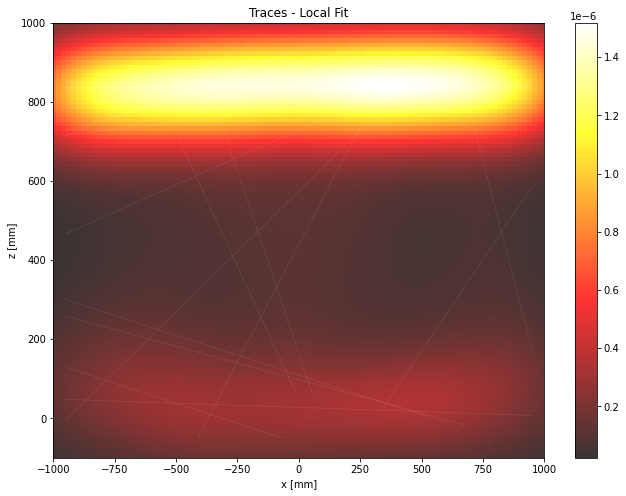

Mean Chi2 6.78948641349889


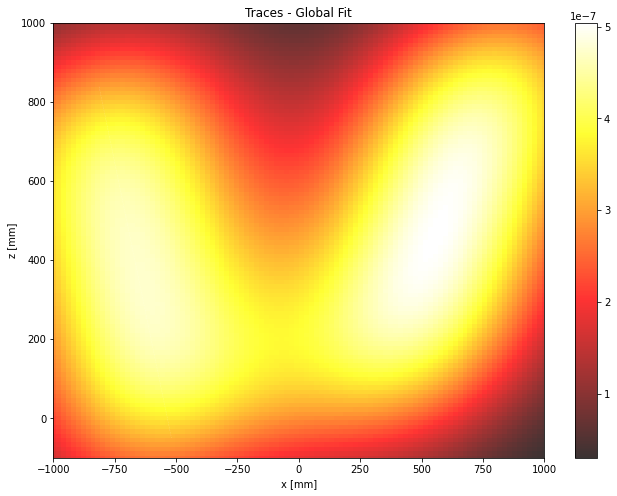

Mean Chi2 2.030608637857613


In [ ]:
data = pd.read_csv('run_000331_global.csv')

plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=False)
plot_data(data, n=100, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=True)

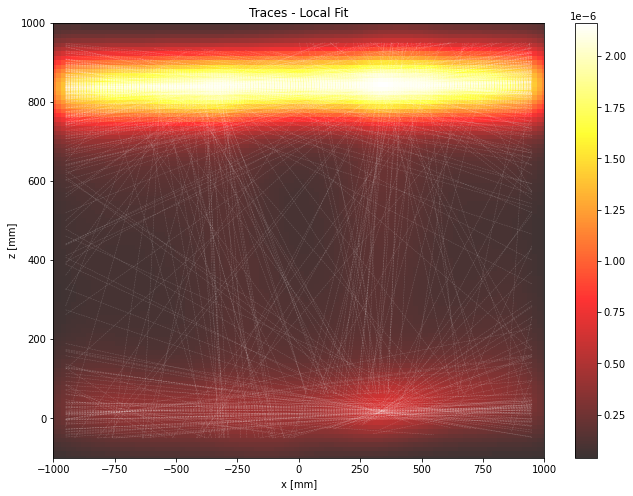

Mean Chi2 4.00358428499438


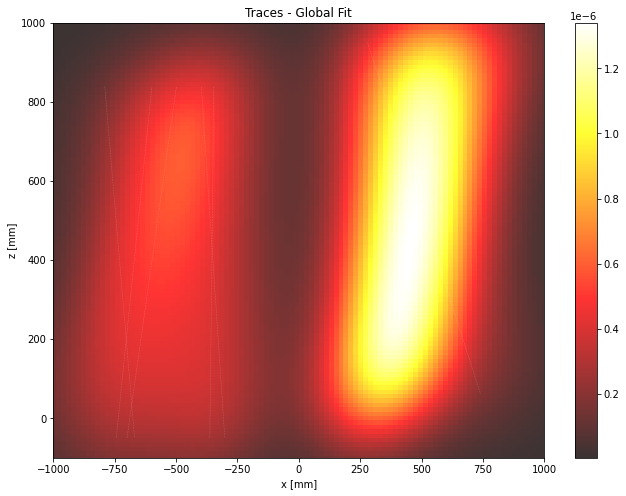

Mean Chi2 1.6495715584189832


In [ ]:
data = pd.read_csv('run_000332_global.csv')

plot_data(data, n=2500, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=False)
plot_data(data, n=2500, plot_only_fit=True, num_workers=2, plot_as_heatmap=True, use_global_fit=True)

We can see that the selection process seems to work: now we have only the hits from detector 0-1 and 2-3.

#### Conclusion

In conclusion, in this project first, we rearranged the preprocess data (of the calibration runs) in order to import it into python as a pandas data frame, then, selecting a certain event, we display all the hits recorded in that event in a determined run.

We then proceeded on the selection of the good hits (the one that hits either detector 0-1 or 2-3) and the following local and global fit. Once we had the results of the linear fit, we plotted them together with the hits, recreating the image present in the assignment.

Lastly, we performed the same steps for the physical runs, stopping at the selection of good events.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ab1dc03-9ec6-464c-8ad6-0ce9b1b292a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>